# Dimension adaptive sampling tutorial

Here, briefly describe the concept behind dimension-adaptive sparse grids, starting from a standard Stochastic Collocation (SC) campaign. Following this, a dimension adaptive EasyVVUQ script using a simple analytic test function is presented. We will assume you are familiar with the basics of EasyVVUQ.

## Standard SC

In a standard EasyVVUQ Campaign, a Stochastic Collocation sampler object might be created via::

```python
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=2)
```
Here the specified `polynomial_order`, and the number of inputs in `vary`, determine the
number of samples, which increases exponentially fast with an increasing amount of inputs. This
is the so-called *curse of dimensionality*. 

Basically, by setting `polynomial_order=2` we create a sampling plan through a single tensor product of one-dimensional quadrature nodes with order 3 for every input. It is this tensor product construction that leads to the exponential rise in cost. So if we have 2 inputs `x1` and `x2`, and our one-dimensional quadrature rule of order 2 produces 5 points, we obtain a total of 25 points in the `(x1, x2)` domain. Likewise, if `vary` contains 3 inputs, we would need to evaluate the computational model 125 times, and 10 inputs would require `5**10 = 9765625` model evaluations. For this reason, a standard SC campaign is rarely used beyond 6 or 7 inputs.

## Sparse SC

Sparse grids on the other hand, do not create a single tensor product, but build the sampling plan from the ground up by using a *linear combination of tensor products involving 1D quadrature rules of* ***different*** *orders*. 

For two inputs, we might for instance consider using 1D quadrature rules of order [0, 0], [0, 1] and [1, 0], where:

    * [0, 0]: a single point in the 2D domain (x1, x2)
    * [0, 1]: a line of 3 points with constant x1
    * [1, 0]: a line of 3 points with constant x2

In the case of sparse grids it is common to select a *nested* quadrature rule. This means that the quadrature
rule of order p contains all points of the same rule of order p-1. When taking the linear combinations, a nested rule ensures that many points will conincide, which yields efficient sampling 
plans, especially in higher dimensions. If our nested 1D rule of order 1 and 2 generates the points [0.5] and [0, 0.5, 1] we obtain a sampling plan consisting of

    * [0, 0]: [0.5, 0.5]
    * [0, 1]: [0.5, 0.0], [0.5, 0.5], [0.5, 1.0]
    * [1, 0]: [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],

which gives a total of 5 unique points, compared to a corresponding standard SC campaign with [1, 1], which would generate 9 unique points (`[0, 0.5, 1] x [0, 0.5, 1.0]`). Note that sparse grids do **not** circumvent the curse of dimensionality, although they can postpone its effect to higher dimensions.

## Dimension-adaptive SC

What we described above is an *isotropic* sparse grid, since the multi indices `[0, 0], [1, 0], [0,1]` result in a sampling plan where both inputs end up with the same number of samples. However, in practice model parameters are rarely equally important. The idea behind dimension-adaptive sampling is to build the sampling plan in an iterative fashion, find out which (combination of) parameters are important as we go, and then place more samples along those directions. This results in a anisotropic sampling plan, where the important inputs get relatively high number of samples. To find out which directions are important we need an appropriate error measure, and we need to split the quadrature order multi indices in an *accepted* and an *admissible* set. The accepted set is initialized to `[0, 0]` in 2D, i.e. we start with just a single code evaluation. Without going into detail, we can think of the admissible set as the candidate refinement directions, from which we must add a single entry to the accepted set at every iteration.

In our 2D example, at the 1st iteration the candidate set consists of `[1, 0]` and `[0, 1]`. That is, we can either refine only `x1` or only `x2`. We must select the multi index which generates the highest error when added to the accepted set. There are a variety of error measures, the two main ones in EasyVVUQ are:

1. the hierarchical surplus error, and
2. a variance-based error.

Roughly speaking, the surplus is an interpolation based error, which measures the difference between the code output and the corresponding SC polynomial surrogate, when evaluated at new sample locations. The variance-based error selects the direction in which the variance in the output changes the most. For more information we refer to the references below.

Assume that `[1, 0]` generated the highest error, and so it is added to the accepted set, now consisting of `[0, 0]` and `[1, 0]`. This means that `x1` has more points than `x2`. Also, adding a multi index to the accepted set means that the admissible set changes. In this case, since `[1, 0]` has been accepted, `[2, 0]` has become admissible. Note that the new entry `[2, 0]` also requires new evaluations of the code, and so a new ensemble must be submitted. Again, if we use a nested rule, the grid of `[2, 0]` will have a partial overlap with the accepted points, so we only have to evaluate the code at the new points, *not* all points of `[2, 0]`.

Thus, the admissible set now consists of `[0, 1]` and `[2, 0]`. Hence, we now have to option of refining `x1` again (to second order), or refining `x2` to first order. Assume the latter happens. As both `x1` and `x2` have been refined to 1st order, `[1, 1]` has become admissible. If accepted, this multi index results in a *simultaneous* refinement of both `x1` and `x2`. Note that `[1, 1]` represents a tensor product, and that therefore it is not the same as `[1, 0]` and `[0, 1]` taken together. We added this example to show that the algoritmn is not limited to one-at-a-time refinement.

To conclude, every time a multi index is accepted, new indices become admissible, and the cycle repeats.

## References

Our description of the method here was rather limited, so for more information and applications of this (and similar) methods, see the following references:

* T. Gerstner  and M. Griebel. "Dimension–adaptive tensor–product quadrature." Computing 71.1 (2003): 65-87.
* W. Edeling , H. Arabnejad , R. Sinclair, D. Suleimenova, K. Gopalakrishnan, B. Bosak, D. Groen, I. Mahmood, D. Crommelin, and Peter V Coveney, "The Impact of Uncertainty on Predictions of the CovidSim Epidemiological Code", Nature Computational Science, 1 (2), 2021.
* D. Loukrezis, U. Römer, and H. De Gersem. "Assessing the performance of Leja and Clenshaw-Curtis collocation for computational electromagnetics with random input data". International Journal for Uncertainty Quantification , 9(1), 2019.
* J.D. Jakeman, M.S. Eldred, G. Geraci, and A. Gorodetsky. "Adaptive multi-index collocation for uncertainty quantification and sensitivity analysis". Numerical Methods in Engineering , 121(6):1314-1343, 2020.

## Example

Below we give an EasyVVUQ script for a dimension-adaptive campaign on a simple polynomial function with 20 uncertain inputs. The function is given by:

```python
    sol = 1.0
    for i in range(d):
        sol *= 3 * a[i] * theta[i]**2 + 1.0
    return sol/2**d
```

Thus, it is just a product of quadratic polynomials. The coefficients `a[i]` are given by

```python
a = [1/(2*(i+1)) for i in range(d)]
```
Such that `a=[0.5, 0.25, 0.125, ..., 1/2**20]`. That is, we have imposed that `x1` is the most important, then `x2` etc. The variables near `x20` virtually do not contribute at all. We would like to pick up on this, and only refine the first couple of inputs.

In [1]:
#!pip install EasyVVUQ
#!pip install future
#!pip install fipy

In [2]:
import easyvvuq as uq
import numpy as np
import chaospy as cp
import os
import matplotlib.pyplot as plt
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, CleanUp, ExecuteLocal, Actions

Running an adaptive campaign starts exactly the same as creating a 'normal' SC campaign, with the exception of a few extra flags that are passed to the SC sampler object. We therefore start as usual with creating a Campaign,  encoder and decoder, and setting up the parameters space:

In [3]:
# The number of uncertain inputs
d = 20

#All parameters are between 0 and 1
params = {}
for i in range(d):
    params["x%d" % (i + 1)] = {"type": "float",
                               "min": 0.0,
                               "max": 1.0,
                               "default": 0.5}
    
#also store the name of the output file and the stochastic dimension
params["out_file"] = {"type": "string", "default": "output.csv"}
params["d"] = {"type": "integer", "default": d}
output_filename = params["out_file"]["default"]
output_columns = ["f"]

# Create an encoder, decoder and collation element
encoder = uq.encoders.GenericEncoder(
    template_fname='poly_model.template',
    delimiter='$',
    target_filename='poly_in.json')


decoder = uq.decoders.SimpleCSV(target_filename=output_filename,
                                output_columns=output_columns)


execute = ExecuteLocal('{}/poly_model.py poly_in.json'.format(os.getcwd()))


actions = Actions(CreateRunDirectory('/tmp'), 
                  Encode(encoder), execute, Decode(decoder))


# Create an EasyVVUQ campaign
campaign = uq.Campaign(name='sc_adaptive', work_dir='/tmp', params=params, actions=actions)


# All inputs are uniformly distributed
vary = {}
for i in range(d):
    vary["x%d" % (i + 1)] = cp.Uniform(0, 1)


As mentioned, the sampler is a bit different:

In [4]:
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=1,
                                quadrature_rule="C",
                                sparse=True, growth=True,
                                midpoint_level1=True,
                                dimension_adaptive=True)

Here:

* `polynomial_order=1`: do not change, will be adaptively increased for influential parameters. Technically, it'll change the quadrature order for different (combinations of) parameters).
* `quadrature_rule="C":`selects the Clenshaw Curtis quadrature rule. This is a common choice, although others are available.
* `sparse = True`: selects a sparse grid. This is required.
* `growth = True`: selects a nested quadrature rule (a quadrature rule such that a 1D rule of order p contains all points of the same rule of order p-1). Also not required, but is efficient in high dimensions. Note that this can only be selected with a subset of all quadrature rules in Chaospy, including Clenshaw Curtis.
* `midpoint_level1=True`: this means that the first iteration of the dimension-adaptive sampler consists of a single sample. 
* `dimension_adaptive=True`: selects the dimension-adaptive sparse grid sampler (opposed to the isotropic sparse grid sampler, which treats each input the same).

In [5]:
# set the sampler, and draw the first sample
campaign.set_sampler(sampler)
campaign.execute().collate(progress_bar=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


In [6]:
# Create an analysis class and run the analysis.
campaign.get_collation_result()

,run_id,iteration,x1,x2,x3,x4,x5,x6,x7,x8,...,x14,x15,x16,x17,x18,x19,x20,out_file,d,f
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,output.csv,20,0.000003


In [7]:
# Create an analysis class and run the analysis.
campaign.get_collation_result()
analysis = uq.analysis.SCAnalysis(sampler=sampler, qoi_cols=output_columns)
campaign.apply_analysis(analysis)

/home/wouter/.local/lib/python3.7/site-packages/easyvvuq-1.1.2+4.g1dc8e9da-py3.7.egg/easyvvuq/analysis/sc_analysis.py:1118: RuntimeWarning: invalid value encountered in true_divide
  S_u[u] = D_u[u] / D


A standard SC (or PCE) campaign would be over at this point. Except we have thus far only sampled a single point in the stochastic domain. To show this, we define the following function to plot 2D slices of the *accepted* points in the 20 dimensional input space. The `analysis.l_norm` array contains the accepted multi indices.

In [8]:
def plot_grid_2D():
    fig = plt.figure(figsize=[12,4])
    ax1 = fig.add_subplot(131, xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel='x1', ylabel='x2', title='(x1, x2) plane')
    ax2 = fig.add_subplot(132, xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel='x3', ylabel='x4', title='(x3, x4) plane')
    ax3 = fig.add_subplot(133, xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel='x19', ylabel='x20', title='(x19, x20) plane')
    
    accepted_grid = sampler.generate_grid(analysis.l_norm)
    ax1.plot(accepted_grid[:,0], accepted_grid[:,1], 'o')
    ax2.plot(accepted_grid[:,2], accepted_grid[:,3], 'o')
    ax3.plot(accepted_grid[:,18], accepted_grid[:,19], 'o')
    
    plt.tight_layout()

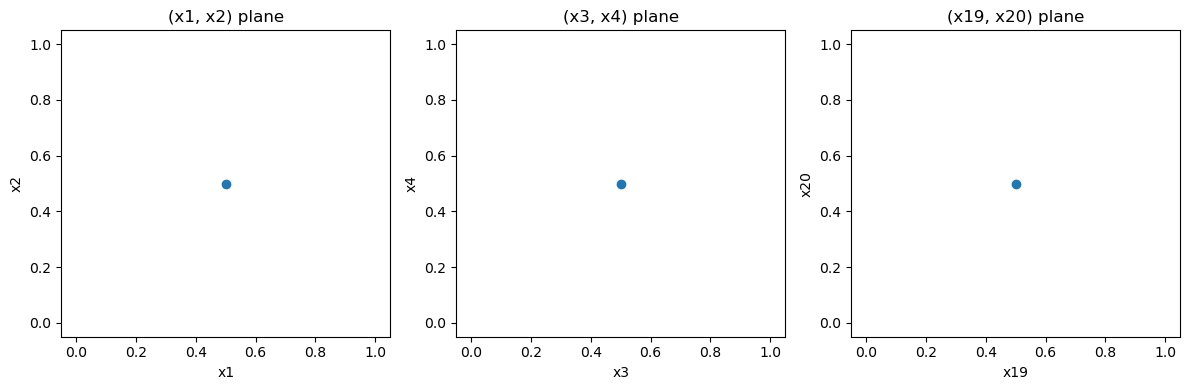

In [9]:
plot_grid_2D()

To refine the sampling plan, we need to:

* Compute the candidate directions of the admissible set. This is done in the `look_ahead` subroutine.
* Run the ensemble of the new points. This is done exactly the same as before.
* Accept the direction with the highest error. This is done in the `adapt_dimension` subroutine.

In [10]:
def refine_sampling_plan(number_of_refinements):
        """
        Refine the sampling plan.

        Parameters
        ----------
        number_of_refinements (int)
           The number of refinement iterations that must be performed.

        Returns
        -------
        None. The new accepted indices are stored in analysis.l_norm and the admissible indices
        in sampler.admissible_idx.
        """
        for i in range(number_of_refinements):
            # compute the admissible indices
            sampler.look_ahead(analysis.l_norm)

            # run the ensemble
            campaign.execute().collate(progress_bar=True)

            # accept one of the multi indices of the new admissible set
            data_frame = campaign.get_collation_result()
            analysis.adapt_dimension('f', data_frame)

Note that the subroutine above uses the surplus error by default. To select the variance-based error use `analysis.adapt_dimension('f', data_frame, method='var')` instead.

In [11]:
# refine the sampling plan once and then do the analysis to see the results.
refine_sampling_plan(1)
campaign.apply_analysis(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.48it/s]


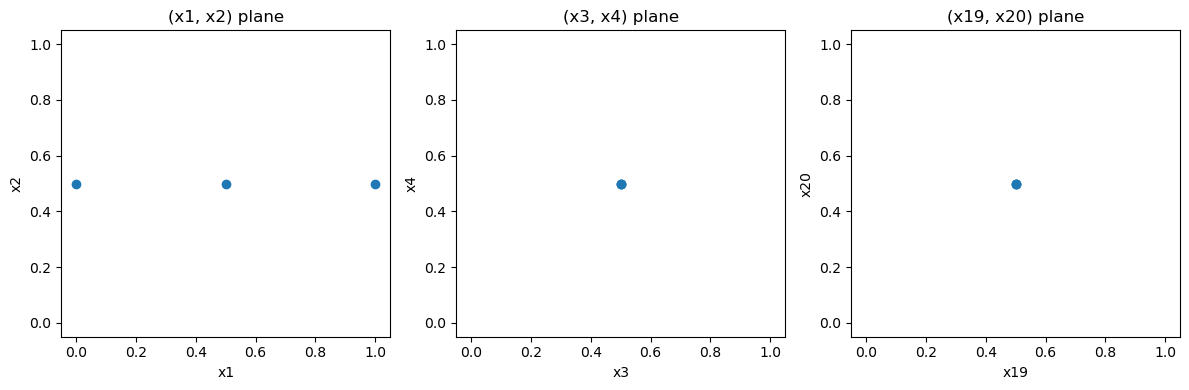

In [12]:
# plot the 2D slices again. Note that the most important input (x1) got refined.
plot_grid_2D()

In [13]:
# repeat
refine_sampling_plan(1)
campaign.apply_analysis(analysis)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.41it/s]


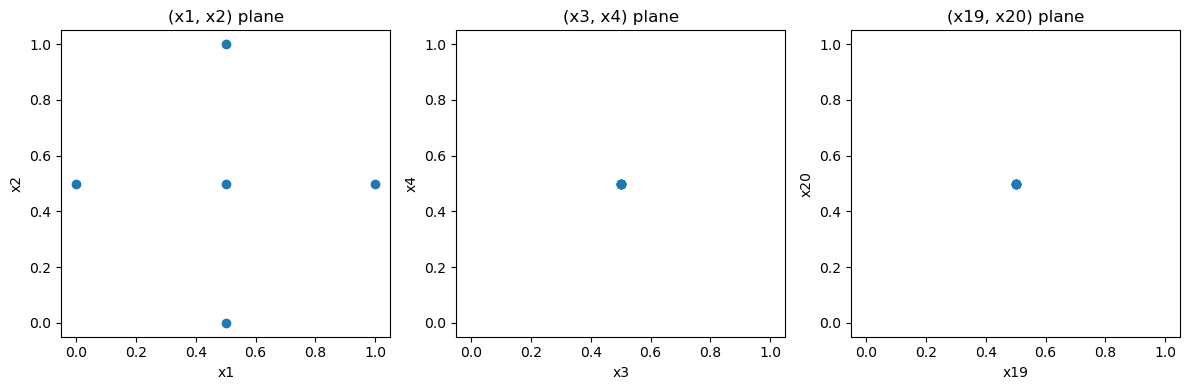

In [14]:
# Now x2 got refined. This makes sense as 3 point along x1 are already enough 
# to capture the second-order polynomial nature. This can also be seen by the printout of
# the error above: "Refinement error for l = (3, 1, 1, ..., 1) is 2.117582368135751e-22".
# This multi index is corresponds to refining x1 again, and the associated error is 
# practically zero, meaning that adding more points in the direction of x1 alone yields
# no improvement.
plot_grid_2D()

In [15]:
# again
refine_sampling_plan(1)
campaign.apply_analysis(analysis)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.65it/s]


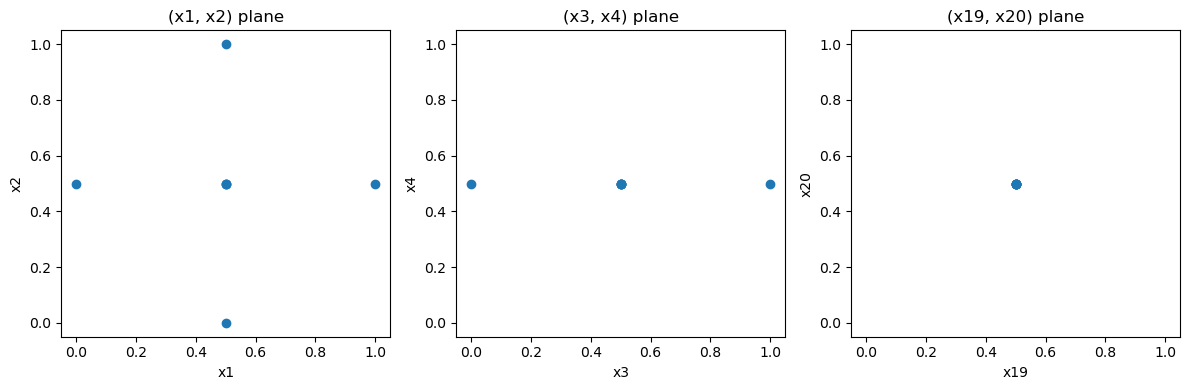

In [16]:
# now x3 got refined to first order
plot_grid_2D()

In [17]:
# we don't have to refine only one time. Here we perform multiple iterations
refine_sampling_plan(20)
campaign.apply_analysis(analysis)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.53it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 22.05it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 25.43it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 28.27it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████

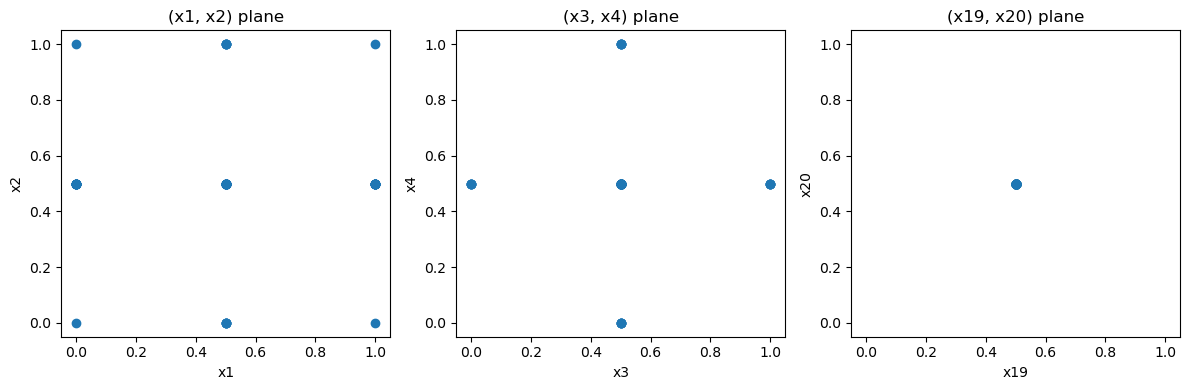

In [18]:
# Plot the slices again. Note that the (x1, x2) plane was refined simultaneously once 
# (by accepting the multi index of quadrature order [1, 1, 0, ... ,0])
plot_grid_2D()

### Post processing

There are a number of post-processing step we can take. Below we show the 'adaptation table' which displays which multi indices were refined at every iteration. Note that at iteration 4, indeed both x1 and x2 were refined at the same time. At iteration 7, x1 and x3 were simultaneously refined to 1st order. It is clear that the algortihm focuses on (combinations of) important parameters first, and keeps the uninfluential parameters at order zero.

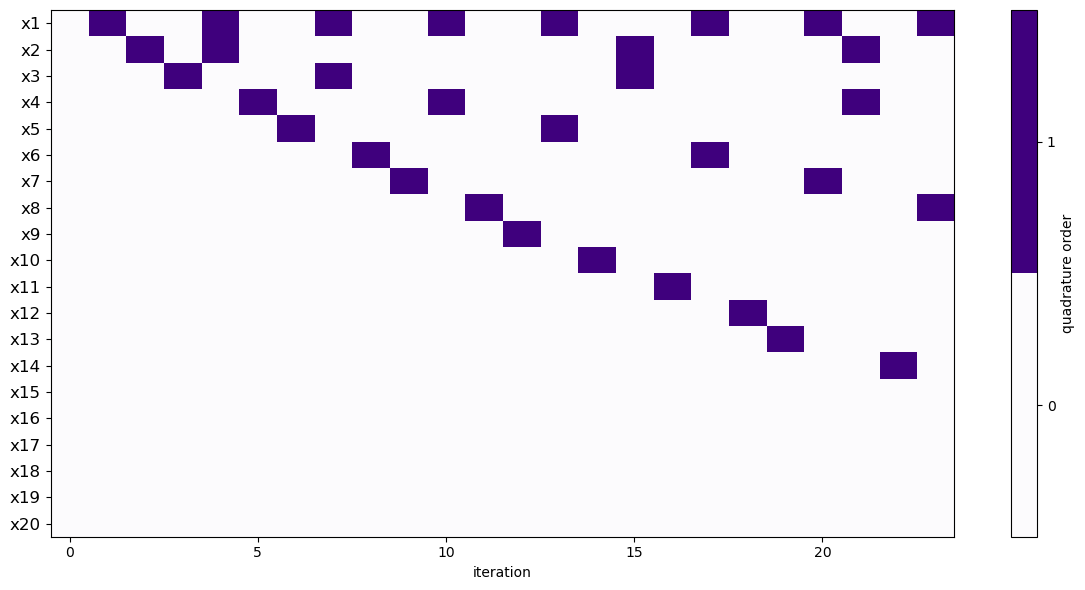

In [19]:
analysis.adaptation_table()

We can also make a histrogram which visualises the adaptation. This displays only a first-order information, i.e. only the maximum quadrature order per input. It therefore does not display that certain inputs were refined simultaneously:

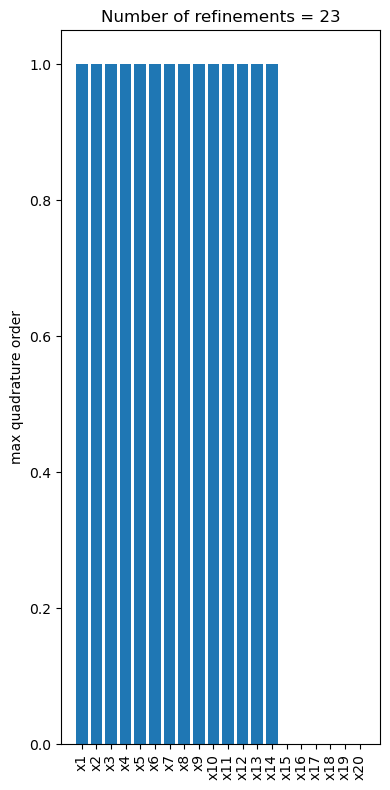

In [20]:
analysis.adaptation_histogram()

To get a list of the error magnitudes associated to the multi indices that were selected use:

In [21]:
analysis.get_adaptation_errors()

[1.8226498377766707e-06,
 1.0552183271338636e-06,
 7.425610450201265e-07,
 5.755736329821073e-07,
 5.728328061583833e-07,
 4.6625926082659077e-07,
 4.050332972837051e-07,
 3.9312055324594937e-07,
 3.3981607144988786e-07,
 3.124542579045724e-07,
 2.992410181424385e-07,
 2.673219762072451e-07,
 2.543232331781408e-07,
 2.4155600259690836e-07,
 2.3449296158530413e-07,
 2.203203100609163e-07,
 2.1442939267960927e-07,
 2.0251664864185235e-07,
 1.8737521696769532e-07,
 1.8535422079084905e-07,
 1.808945703658052e-07,
 1.7434041926559496e-07,
 1.6322237353224039e-07]

This shows a nice monotonic decrease of the error. However, this is due to the fact that we have a simple polynomial test function, and the SC expansion is polynomial as well. More complex simulation codes can show non-monotonic behaviour.

To compute the mean and variance of the code output we use:

In [22]:
df = campaign.get_collation_result()
results = analysis.analyse(df)
print('Mean = %.4e' % results.describe('f', 'mean'))
print('Standard deviation = %.4e' % results.describe('f', 'std'))

Mean = 4.5759e-06
Standard deviation = 1.6954e-06


Here, `'f'` is simply the name of our quantity of interest. We can also compute the exact moments in this case:

In [23]:
a = np.array([1/(2*(i+1)) for i in range(d)])
ref_mean = np.prod(a + 1) / 2**d
ref_std = np.sqrt(np.prod(9 * a**2 / 5 + 2 * a + 1) / 2**(2 * d) - ref_mean**2)
print('Exact mean = %.4e' % ref_mean)
print('Exact standard deviation = %.4e' % ref_std)

Exact mean = 4.9021e-06
Exact standard deviation = 2.1302e-06


We can see that the estimates are fair, although not yet fully converged in this case. Note however that these results are computed only with the accepted set of multi indices. At the end, we can merge the accepted and admissible set (thereby using all samples), and recompute the results:

In [24]:
analysis.merge_accepted_and_admissible()
df = campaign.get_collation_result()
results = analysis.analyse(df)
print('Mean = %.4e' % results.describe('f', 'mean'))
print('Standard deviation = %.4e' % results.describe('f', 'std'))

Mean = 4.8254e-06
Standard deviation = 1.9298e-06


This improved our estimates. Note however, that if we would refine again from this point, the new admissble set will be very large, since we added *all* previous admissible indices to the accepted set. This opens up a wide range of possible new candidate directions, making the corresponding ensemble very large.

Thus if we are still not happy about the result, we first have to undo the merging via `analysis.undo_merge()`, before refining again.

In [25]:
# This will undo the merge, and reproduce the old results
#analysis.undo_merge()
#df = campaign.get_collation_result()
#results = analysis.analyse(df)
#print('Mean = %.4e' % results.describe('f', 'mean'))
#print('Standard deviation = %.4e' % results.describe('f', 'std'))

We can also display the Sobol sensitivity indices via:

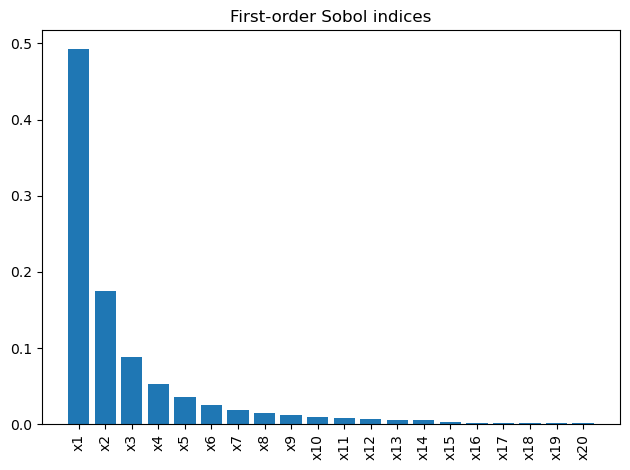

In [26]:
sobols = []
# retrieve the Sobol indices from the results object
params = list(sampler.vary.get_keys())
for param in params:
    sobols.append(results._get_sobols_first('f', param))
# make a bar chart
fig = plt.figure()
ax = fig.add_subplot(111, title='First-order Sobol indices')
ax.bar(range(len(sobols)), height=np.array(sobols).flatten())
ax.set_xticks(range(len(sobols)))
ax.set_xticklabels(params)
plt.xticks(rotation=90)
plt.tight_layout()

Note that the Sobol indices show the expected qualitative behaviour for this model, with x1 being the most important, followed by x2 etc.